# Credit Card Fraud Detection

Throughout the financial sector, machine learning algorithms are being developed to detect fraudulent transactions.  In this project, that is exactly what we are going to be doing as well.  Using a dataset of of nearly 28,500 credit card transactions and multiple unsupervised anomaly detection algorithms, we are going to identify transactions with a high probability of being credit card fraud.  In this project, we will build and deploy the following two machine learning algorithms:

* Local Outlier Factor (LOF)
* Isolation Forest Algorithm

Furthermore, using metrics suchs as precision, recall, and F1-scores, we will investigate why the classification accuracy for these algorithms can be misleading.



In [0]:
# import the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import scipy

### 2. The Data Set

Context

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.
Content

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise. 

In [0]:
# Load the dataset from the csv file using pandas
data = pd.read_csv('https://python-ml.000webhostapp.com/data/creditcard.csv')

In [20]:
# Start exploring the dataset
print(data.columns)

Index([u'Time', u'V1', u'V2', u'V3', u'V4', u'V5', u'V6', u'V7', u'V8', u'V9',
       u'V10', u'V11', u'V12', u'V13', u'V14', u'V15', u'V16', u'V17', u'V18',
       u'V19', u'V20', u'V21', u'V22', u'V23', u'V24', u'V25', u'V26', u'V27',
       u'V28', u'Amount', u'Class'],
      dtype='object')


In [21]:
# Print the shape of the data
print(data.shape)
print(data.describe())

# V1 - V28 are the results of a PCA Dimensionality reduction to protect user identities and sensitive features

(217666, 31)
                Time             V1             V2             V3  \
count  217666.000000  217666.000000  217666.000000  217666.000000   
mean    76046.604766      -0.076770      -0.007915       0.229090   
std     37850.912929       1.919413       1.639948       1.474895   
min         0.000000     -56.407510     -72.715728     -33.680984   
25%     46441.000000      -0.952024      -0.592836      -0.492514   
50%     71097.000000      -0.051096       0.072796       0.413051   
75%    115783.000000       1.233269       0.781253       1.176618   
max    140980.000000       2.454930      22.057729       9.382558   

                  V4             V5             V6             V7  \
count  217666.000000  217666.000000  217666.000000  217666.000000   
mean        0.054046      -0.077811       0.036567      -0.033115   
std         1.406312       1.365773       1.317309       1.221114   
min        -5.683171     -42.147898     -26.160506     -43.557242   
25%        -0.814213

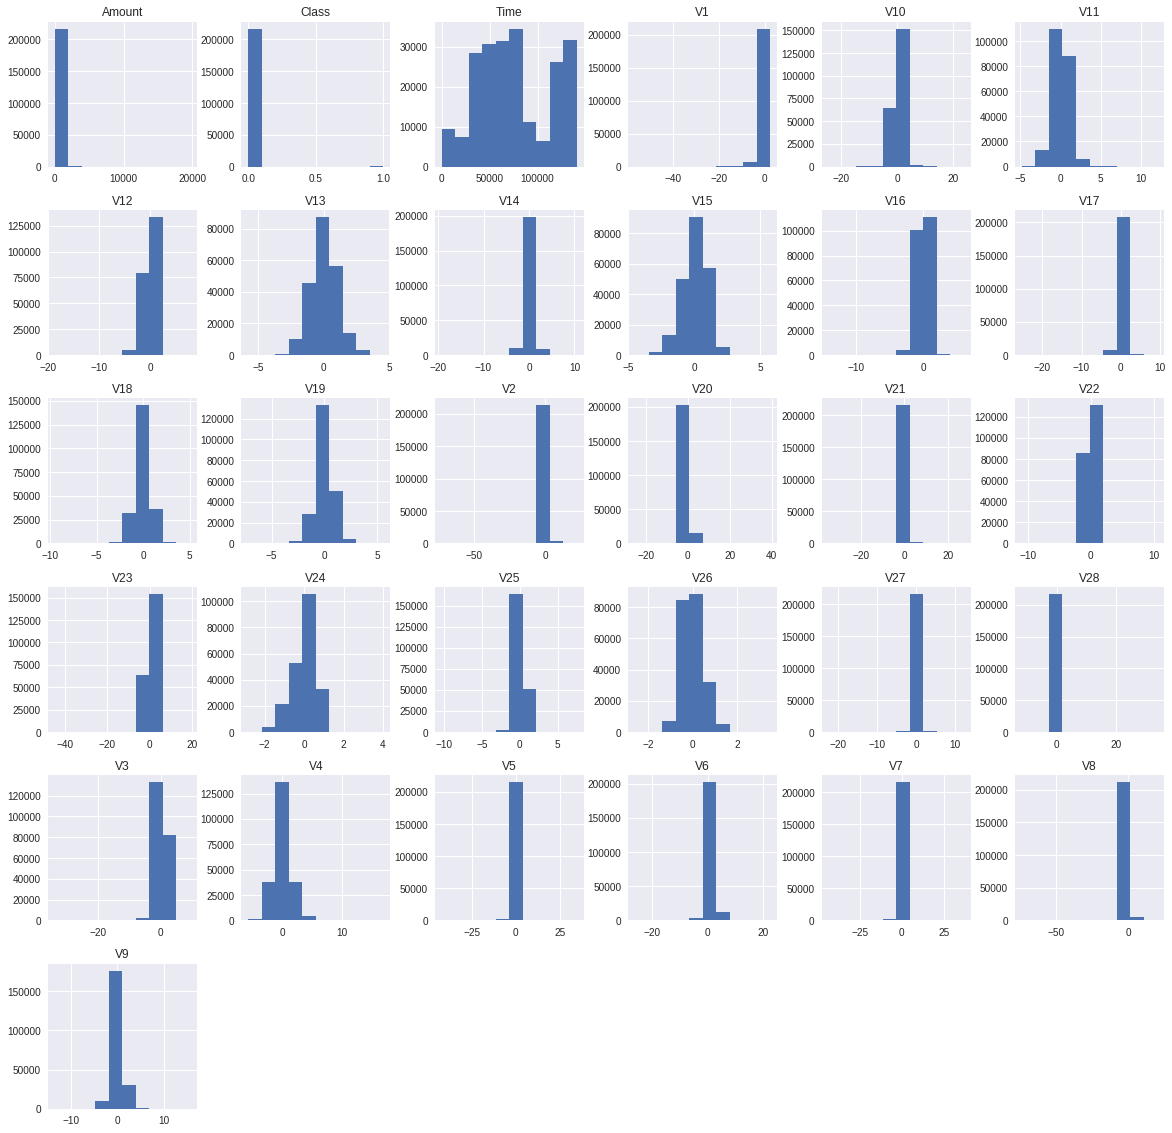

In [22]:
# Plot histograms of each parameter 
data.hist(figsize = (20, 20))
plt.show()

In [23]:
# Determine number of fraud cases in dataset

Fraud = data[data['Class'] == 1]
Valid = data[data['Class'] == 0]

outlier_fraction = len(Fraud)/float(len(Valid))
print(outlier_fraction)

print('Fraud Cases: {}'.format(len(data[data['Class'] == 1])))
print('Valid Transactions: {}'.format(len(data[data['Class'] == 0])))



0.00185489475889
Fraud Cases: 403
Valid Transactions: 217263


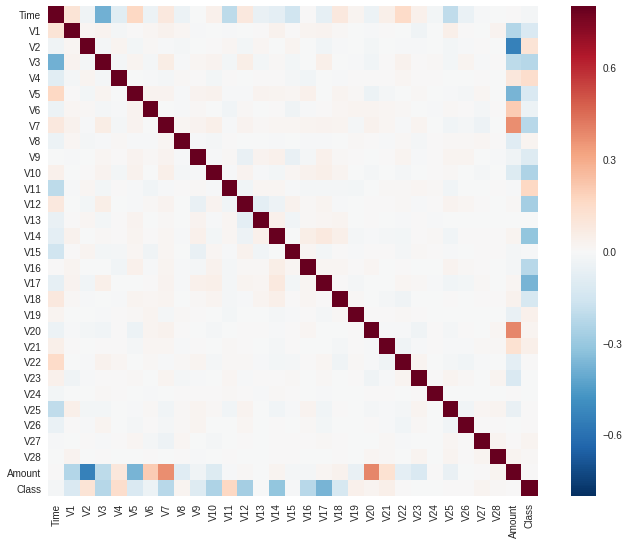

In [24]:
# Correlation matrix
corrmat = data.corr()
fig = plt.figure(figsize = (12, 9))

sns.heatmap(corrmat, vmax = .8, square = True)
plt.show()

In [25]:
# Get all the columns from the dataFrame
columns = data.columns.tolist()

# Filter the columns to remove data we do not want
columns = [c for c in columns if c not in ["Class"]]

# Store the variable we'll be predicting on
target = "Class"

X = data[columns]
Y = data[target]

# Print shapes
print(X.shape)
print(Y.shape)

(217666, 30)
(217666,)


## 3. Unsupervised Outlier Detection

Now that we have processed our data, we can begin deploying our machine learning algorithms.  We will use the following techniques: 

**Local Outlier Factor (LOF)**

The anomaly score of each sample is called Local Outlier Factor. It measures the local deviation of density of a 
given sample with respect to its neighbors. It is local in that the anomaly score depends on how isolated the 
object is with respect to the surrounding neighborhood.


**Isolation Forest Algorithm**

The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting 
a split value between the maximum and minimum values of the selected feature.

Since recursive partitioning can be represented by a tree structure, the number of splittings required to 
isolate a sample is equivalent to the path length from the root node to the terminating node.

This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

Random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees 
collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.

In [0]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# define random states
state = 1

# define outlier detection tools to be compared
classifiers = {
    "Isolation Forest": IsolationForest(max_samples=len(X),
                                        contamination=outlier_fraction,
                                        random_state=state),
    "Local Outlier Factor": LocalOutlierFactor(
        n_neighbors=20,
        contamination=outlier_fraction)}

In [27]:
# Fit the model
plt.figure(figsize=(9, 7))
n_outliers = len(Fraud)


for i, (clf_name, clf) in enumerate(classifiers.items()):
    
    # fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_pred = clf.negative_outlier_factor_
    else:
        clf.fit(X)
        scores_pred = clf.decision_function(X)
        y_pred = clf.predict(X)
    
    # Reshape the prediction values to 0 for valid, 1 for fraud. 
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    
    n_errors = (y_pred != Y).sum()
    
    # Run classification metrics
    print('{}: {}'.format(clf_name, n_errors))
    print(accuracy_score(Y, y_pred))
    print(classification_report(Y, y_pred))


Local Outlier Factor: 759
0.9965130061654094
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    217263
          1       0.06      0.06      0.06       403

avg / total       1.00      1.00      1.00    217666

Isolation Forest: 519
0.997615612911525
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    217263
          1       0.36      0.36      0.36       403

avg / total       1.00      1.00      1.00    217666



# 4. Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import train_test_split


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.70, test_size=0.30, random_state=1)

In [32]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [0]:
pred = model.predict(X_test)

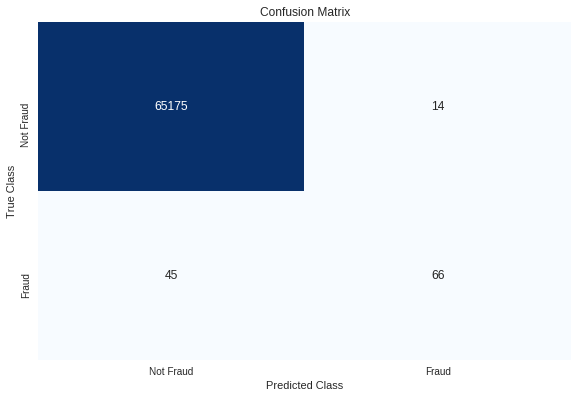

In [36]:
class_names = ['Not Fraud', 'Fraud']
matrix = confusion_matrix(y_test, pred)

dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)

sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues", fmt = 'g')
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

**Evaulation**

For a financial institution dealing with identifying fraud, Sensitivity and F1 - Score might be more important metrics. F1- Score reprsents a more balanced result as it is the harmonic mean between Precision and Recall. Sensitivity is more important in the sense that we are more interested in identifying fraud than than identifying legitimate customers. ( Assumption )

In [37]:
from sklearn.metrics import f1_score, recall_score
f1_score = round(f1_score(y_test, pred), 2)
recall_score = round(recall_score(y_test, pred), 2)
print("Sensitivity/Recall for Logistic Regression Model 1 : {recall_score}".format(recall_score = recall_score))
print("F1 Score for Logistic Regression Model 1 : {f1_score}".format(f1_score = f1_score))

Sensitivity/Recall for Logistic Regression Model 1 : 0.59
F1 Score for Logistic Regression Model 1 : 0.69


# Deep Learning using Keras

In [0]:
#Standardize the features for speeding up deep learning (MinMaxScaler)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 200)               6200      
_________________________________________________________________
dropout_19 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_20 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 201       
Total params: 46,601
Trainable params: 46,601
Non-trainable params: 0
_________________________________________________________________
None
Train on 30473 samples, validate on 121893 samples
Epoch 1/200
 - 2s - loss: 0.1551 - acc: 0.9843 - val_loss: 0.0168 - val_acc: 0.998

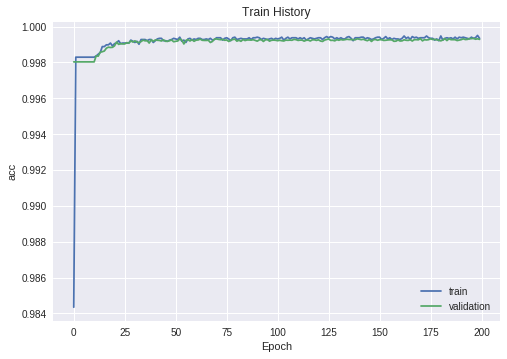

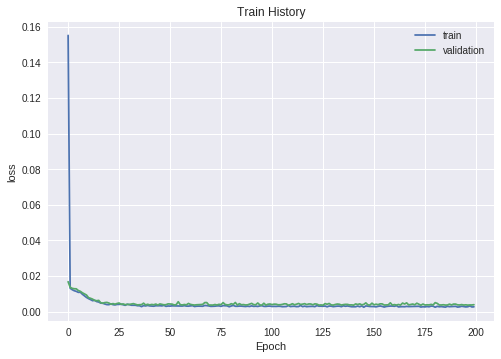

65300/65300 [==============================] - 2s 35us/step


('Accuracy=', 0.9993568147013783)


In [49]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

import matplotlib.pyplot as plt 
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()

model = Sequential()


model.add(Dense(units=200, 
                input_dim=30, 
                kernel_initializer='uniform', 
                activation='relu'))
model.add(Dropout(0.5))


model.add(Dense(units=200,  
                kernel_initializer='uniform', 
                activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1,
                kernel_initializer='uniform',
                activation='sigmoid'))

print(model.summary()) 

model.compile(loss='binary_crossentropy',  
              optimizer='adam', metrics=['accuracy'])

train_history = model.fit(X_train, y_train,
                          validation_split=0.8, epochs=200, 
                          batch_size=500, verbose=2) 

show_train_history(train_history,'acc','val_acc')
show_train_history(train_history,'loss','val_loss')


scores = model.evaluate(X_test, y_test)
print('\n')
print('Accuracy=',scores[1])

prediction = model.predict_classes(X_test)
